In [1]:
from lms2 import DrahixMicrogridV2, Time, pplot

from pyomo.environ import TransformationFactory, SolverFactory
import matplotlib.pyplot as plt
import pandas as pd
import os
import time


def to_seconds(timedelta):
    return timedelta.days * 24 * 3600 + timedelta.seconds + timedelta.microseconds / 1e6


In [2]:
os.chdir('/home/admin/Documents/02-Recherche/02-Python/pypeper/')
usecols = ['Date and time (UTC)', 'TGBT', 'Pmax']
df = pd.read_csv('pypeper/data/DrahiX_SIRTA_eCO2mix_20160715_20180930.csv',
                 usecols=usecols, index_col=0, parse_dates=True, dayfirst=True)


In [3]:
# selecting time period and time discretization
t_start = '2018-06-01 00:00:00'
t_end = '2018-06-15 00:00:00'
freq = '15Min'

t = Time(t_start, t_end, freq=freq)
df = df[t_start:t_end]

# change index from timestamps to second
df.index = to_seconds(df.index - df.index[0])
df['Pmax'] = df['Pmax'].fillna(0)/1000
df.rename(columns={'Pmax': 'P_pv', 'TGBT': 'P_load'}, inplace=True)

df = df.apply(lambda x: round(x, 3))

In [4]:
m = DrahixMicrogridV2(name='m', dataframe=df)

m.obj = m.construct_objective_from_expression_list(m.t, m.mg.instant_cost, m.ps.instant_cost)
# m.construct_objective_from_tagged_expression()

# m.ps.scale_fact.setlb(10)
# m.ps.scale_fact.setub(500)
m.ps.scale_fact.fix(200)


In [5]:
t1 = time.time()
discretizer = TransformationFactory('dae.finite_difference')
discretizer.apply_to(m, nfe=t.nfe)  # BACKWARD or FORWARD
t2 = time.time() - t1
print(f'Elapsed time for discretization : \t {t2}')


Elapsed time for discretization : 	 0.9060909748077393


In [6]:
# m.construct_integrals()
# opt = SolverFactory("gurobi", solver_io="direct")
opt = SolverFactory("glpk")
# opt = SolverFactory("cbc")

t1 = time.time()
# opt.options['tmlim'] = 120
# opt.options['allow'] = 0.1
results = opt.solve(m, tee=False) # tee = true for more outpus
t2 = time.time() - t1
print(f'Elapsed time : \t {t2}')

print(results)
print(m.obj())

Elapsed time : 	 4.172119140625

Problem: 
- Name: unknown
  Lower bound: -28.1500033599997
  Upper bound: -28.1500033599997
  Number of objectives: 1
  Number of constraints: 17488
  Number of variables: 16141
  Number of nonzeros: 37661
  Sense: minimize
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 507
      Number of created subproblems: 507
  Error rc: 0
  Time: 3.46696138381958
Solution: 
- number of solutions: 0
  number of solutions displayed: 0

-28.150003359999744


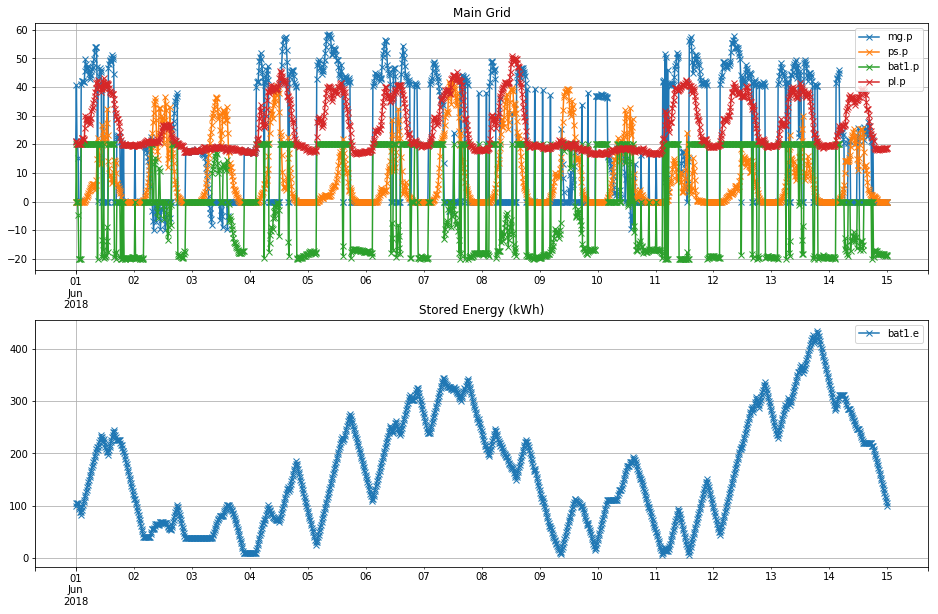

In [7]:
f = plt.figure(figsize=(16,10))
ax = f.subplots(2, 1)

pplot(m.mg.p, m.ps.p, m.bat1.p, m.pl.p, fig=f, ax=ax[0], index=t.datetime, legend=True, title='Main Grid', Marker='x')
plt.grid(True)
pplot(m.bat1.e, fig=f, ax=ax[1], index=t.datetime, legend=True, title='Stored Energy (kWh)', Marker='x')
plt.grid(True)
